# Sample QC

This notebook is a quick guide to how sketching algorithms can be used for sample QC. The particular emphasis is on getting from raw sequencing data to filtered reads, which we will then use in the next steps of our genomics workflow.

> Note: many sketching algorithms can work with raw data, which contributes to the speed benefits of sketching. That being said, if we want more than just a quick and dirty analysis, it's always best to QC your data...

We'll use the following sketching algorithms, implemented via some excellent open-source bioinformatics software:

* MinHash
* CountMin sketch
* Bloom filter

***

## The data

As mentioned in 4.1, we are looking at a suspected outbreak of *E.cloacae* in a hospital. We are using the sequence data collected during the [Reuter et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4001082/) study. The following table contains the accessions for the isolates we need, I just grabbed this from the [supplementary file](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4001082/bin/NIHMS58061-supplement-Supplementary_Online_Content.pdf) and then added the ENA experiment IDs.

|strain name|patient ID|ENA sample|ENA experiment|
|-|-|-|-|
EC1a|EC1|ERS184249|ERX168346|
EC2a|EC2|ERS184250|ERX168347|
EC2b|EC2|ERS184251|ERX168341|
EC3a|EC3|ERS184252|ERX168340|
EC4a|EC4|ERS184245|ERX168345|
EC5a|EC5|ERS184246|ERX168339|
EC6a|EC6|ERS184247|ERX168343|
EC7a|EC7|ERS184248|ERX168344|

These samples correspond to whole genome sequence data for *E.cloacae* isolates, collected from several patients in the hospital during the suspected outbreak.

To save us the pain of waiting for fastq-dump to collect the data, I have already downloaded it. For future reference though, use `fastq-dump` (part of [sra-tools](https://github.com/ncbi/sra-tools)) to download this data from the ENA. We could have sketched this download data stream, but as we know that we need this data for our analysis it is best to have it stored on disk. You'll see later how we can sketch a data stream from a download, evaluate these sketches to see if the data is helpful for our analysis, and then decide to store or discard it.

The sequence data for these isolates is actually pretty poor quality - [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) showed the terminal 50 bases to be full of Ns and the quality dropped below Q20. So I ran Trimmomatic to clean the data, here is the command ran for one sample:

```
trimmomatic PE ERX168346_1.fastq ERX168346_2.fastq ERX168346_1-trimmed.fq ERX168346_1-se ERX168346_2-trimmed.fq ERX168346_2-se SLIDINGWINDOW:5:20 MINLEN:100 MAXLEN:140
```

So, we now have quality checked, trimmed sequence data for each sample downloaded and ready to go. This is stored in `../data/reads`. To make things easier to follow, the following steps will be ran on just one of these samples. Feel free to update the code to run on all of them!

## Sanity check

Are my samples what I think they are?!

The study labelled these isolates as *E.cloacae*, let's use **MinHash** to check. We'll be using the excellent [sourmash](https://github.com/dib-lab/sourmash) software. The sourmash docs actually have loads of great examples and workflows - be sure to check them out too.


* start with downloading a reference database of MinHash genome sketches:

In [71]:
# download the pre-made MinHash database (courtesy of sourmash) containing all GenBank microbial genomes
!wget -O genbank-k31.lca.json.gz https://osf.io/4f8n3/download

--2019-04-08 13:42:49--  https://osf.io/4f8n3/download
Resolving osf.io... 35.190.84.173
Connecting to osf.io|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/vk4fa/providers/osfstorage/5c17c7754eb58100178fa5b3?action=download&version=1&direct [following]
--2019-04-08 13:42:50--  https://files.osf.io/v1/resources/vk4fa/providers/osfstorage/5c17c7754eb58100178fa5b3?action=download&version=1&direct
Resolving files.osf.io... 35.186.214.196
Connecting to files.osf.io|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125814027 (120M) [application/octet-stream]
Saving to: 'genbank-k31.lca.json.gz'

genbank-k31.lca.jso 100%[===================>] 119.99M  4.37MB/s    in 28s     

2019-04-08 13:43:20 (4.28 MB/s) - 'genbank-k31.lca.json.gz' saved [125814027/125814027]



* next, create a MinHash sketch of the reads from one sample:

In [72]:
# sketch the reads from a sample
!sourmash compute --scaled 1000 -k 31 ../data/reads/ERX168346_*-trimmed.fq.gz --merge ERX168346 -o ERX168346.sketch 

== This is sourmash version 2.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

setting num_hashes to 0 because --scaled is set
computing signatures for files: ../data/reads/ERX168346_1-trimmed.fq.gz, ../data/reads/ERX168346_2-trimmed.fq.gz
Computing signature for ksizes: [31]
Computing only nucleotide (and not protein) signatures.
Computing a total of 1 signature(s).
... reading sequences from ../data/reads/ERX168346_1-trimmed.fq.gz
... ../data/reads/ERX168346_1-trimmed.fq.gz 125643 sequences
... reading sequences from ../data/reads/ERX168346_2-trimmed.fq.gz
... ../data/reads/ERX168346_2-trimmed.fq.gz 125643 sequences
calculated 1 signatures for 251286 sequences taken from 2 files
saved 1 signature(s). Note: signature license is CC0.


> the --scaled flag tells sourmash to decide the number of hashes to include in the MinHash sketch. Sourmash decides this based on the sequence length; it is effectively setting a compression ratio of 1000-to-1.

> make sure that k-mer size for the sketch matches the k-mer size of the reference database (31)

> the --merge flag tells sourmash to combine all the sketches into a single sketch. This is needed as our data is paired-end and we just want to have a single sketch per sample.

* now we have sketched our sample, we can compare it to the reference sketches and check we have the organism we expect (e.cloacae!):

In [73]:
# compare the sketch of the reads against each sketch in the reference database
!sourmash gather -k 31 ERX168346.sketch genbank-k31.lca.json.gz

== This is sourmash version 2.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded query: ERX168346... (k=31, DNA)
loaded 1 databases.                                                            


overlap     p_query p_match
---------   ------- -------
4.4 Mbp       95.1%   91.7%    FKBP01000001.1 Enterobacter cloacae s...
found less than 10.0 kbp in common. => exiting

found 1 matches total;
the recovered matches hit 95.1% of the query



So the sketch from our sample matches the sketch of the E.cloacae reference genome - yay!

It wasn't a complete match however, there is a little bit of a difference between the sketches. This is probably due to sequencing error. We will have a fair few unique k-mers in the sequencing data, which typically arise from errors during sequencing (but could also be from strain variation).

Let's use some more sketching to investigate!


## K-mer spectrum

First off, let's check that our guess is right. Do we have a lot of unique k-mers? To answer this, we'll use the **Count-Min sketch** and another piece of software from Titus Brown et al. - [khmer](https://github.com/dib-lab/khmer).

* begin by using a Count-Min sketch to create a k-mer count graph (the k-mer spectrum):

In [88]:
!abundance-dist-single.py -M 1e9 -k 21 -s ../data/reads/ERX168346_1-trimmed.fq.gz ERX168346.dist


|| This is the script abundance-dist-single.py in khmer.
|| You are running khmer version 3.0.0a2
|| You are also using screed version 1.0
||
|| If you use this script in a publication, please cite EACH of the following:
||
||   * MR Crusoe et al., 2015. http://dx.doi.org/10.12688/f1000research.6924.1
||   * Q Zhang et al., http://dx.doi.org/10.1371/journal.pone.0101271
||   * A. Döring et al. http://dx.doi.org:80/10.1186/1471-2105-9-11
||
|| Please see http://khmer.readthedocs.io/en/latest/citations.html for details.


PARAMETERS:
 - kmer size =     21 		(-k)
 - n tables =      4 		(-N)
 - max tablesize = 2.5e+08 	(-x)
Estimated memory usage is 1.0 Gb (1e+09 bytes = 4 bytes x 2.5e+08 entries / 1 entries per byte)
--------
making countgraph
building k-mer tracking graph
kmer_size: 21
k-mer countgraph sizes: [215053697, 215053673, 215053669, 215053667]
outputting to ERX168346.dist
consuming input, round 1 -- ../data/reads/ERX168346_1-trimmed.fq.gz
Total number of unique k-mers: 4289811

* plot the k-mer abundance against k-mer count:

Text(0, 0.5, 'N k-mers with that abundance')

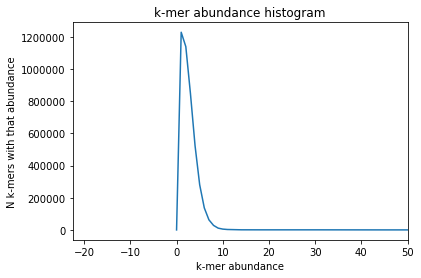

In [89]:
%matplotlib inline
import numpy
from pylab import *
dist1 = numpy.loadtxt('ERX168346.dist', skiprows=1, delimiter=',')
plot(dist1[:,0], dist1[:,1])
axis(xmax=50)
title('k-mer abundance histogram')
xlabel('k-mer abundance')
ylabel('N k-mers with that abundance')

We can see a a lot unique k-mers in that plot. One reason to remove these is to reduce the amount of data we process in downstream analysis, which will reduce analysis time and take less memory (as there are fewer unique k-mers to hold in memory). That being said, it's not really necessary and removing them can have a negative impact on some analyses as we would be reducing coverage.

So instead of removing them, let's first try to correct the sequence reads.

## Read error correction using Bloom filters

For this, we can use [lighter](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0509-9). We need a bit of information first:

* what size is the genome we have sequenced
* how many reads do we have

This information is used to calculate the sequencing coverage, this is then used to set the sampling fraction (alpha) so that it is inversely proportion to the depth of sequencing.

We saw in the output of our earlier khmer command that we have 125643 read pairs (read length ~140bp) for ERX168346. We also know that the genome size of *E.cloacae* is 5.31Mb. So our genome coverage from this sample is approximately 7X (which isn't great, but we did aggressively trim the data as the quality was poor).

We calculate our sampling fraction for each file using the equation from the lighter paper: 7/coverage.

This means our sampling fraction is 2.13

* now let's run lighter:

In [90]:
!lighter -r ../data/reads/ERX168346_1-trimmed.fq.gz -k 17 5310000 2.13
!lighter -r ../data/reads/ERX168346_2-trimmed.fq.gz -k 17 5310000 2.13

[2019-04-08 14:06:17] =============Start====================
[2019-04-08 14:06:17] Bad quality threshold is "5"
[2019-04-08 14:06:20] Finish sampling kmers
[2019-04-08 14:06:20] Bloom filter A's false positive rate: 0.000730
[2019-04-08 14:06:25] Finish storing trusted kmers
[2019-04-08 14:06:29] Finish error correction
Processed 125643 reads:
	115592 are error-free
	Corrected 4969 bases(0.494379 corrections for reads with errors)
	Trimmed 0 reads with average trimmed bases 0.000000
	Discard 0 reads
[2019-04-08 14:06:29] =============Start====================
[2019-04-08 14:06:29] Bad quality threshold is "5"
[2019-04-08 14:06:32] Finish sampling kmers
[2019-04-08 14:06:32] Bloom filter A's false positive rate: 0.000728
[2019-04-08 14:06:37] Finish storing trusted kmers
[2019-04-08 14:06:41] Finish error correction
Processed 125643 reads:
	115301 are error-free
	Corrected 5081 bases(0.491298 corrections for reads with errors)
	Trimmed 0 reads with average trimmed bases 0.000000
	Discar

> lighter needs a k-mer size, the genome size and the alpha. Alpha is optional, but if you don't include it lighter will do an extra pass of your data to calculate it for you.

Lighter corrected around 5000 bases - great! Let's now do some low-abundance k-mer trimming.


## K-mer trimming using Count-Min sketch

Back to the Count-Min sketch and khmer...

* perform k-mer frequency based trimming on the corrected reads from lighter:

> this takes a little while

In [91]:
!trim-low-abund.py -V -M 8e9 -C 3 -Z 10 -o ERX168346.corrected.trimmed.fq ERX168346_1-trimmed.cor.fq.gz ERX168346_2-trimmed.cor.fq.gz


|| This is the script trim-low-abund.py in khmer.
|| You are running khmer version 3.0.0a2
|| You are also using screed version 1.0
||
|| If you use this script in a publication, please cite EACH of the following:
||
||   * MR Crusoe et al., 2015. http://dx.doi.org/10.12688/f1000research.6924.1
||   * Q Zhang, S Awad, CT Brown, https://dx.doi.org/10.7287/peerj.preprints.890v1
||
|| Please see http://khmer.readthedocs.io/en/latest/citations.html for details.


PARAMETERS:
 - kmer size =     32 		(-k)
 - n tables =      4 		(-N)
 - max tablesize = 2e+09 	(-x)
Estimated memory usage is 8.0 Gb (8e+09 bytes = 4 bytes x 2e+09 entries / 1 entries per byte)
--------
making countgraph
created temporary directory ./tmpduxdykibkhmer;
use -T to change location
... ERX168346_1-trimmed.cor.fq.gz 10015 10107 1239533 83 9976
... ERX168346_1-trimmed.cor.fq.gz 19413 20001 2446816 571 68473
... ERX168346_1-trimmed.cor.fq.gz 28563 30006 3665336 1419 170335
... ERX168346_1-trimmed.cor.fq.gz 37536 40015 48

... x 2 280001 ./tmpduxdykibkhmer/ERX168346_2-trimmed.cor.fq.gz.pass2 219335 405644 49249013 185690 22510558
... x 2 290001 ./tmpduxdykibkhmer/ERX168346_2-trimmed.cor.fq.gz.pass2 219335 415644 50455849 195670 23713901
... x 2 300001 ./tmpduxdykibkhmer/ERX168346_2-trimmed.cor.fq.gz.pass2 219335 425644 51661712 205652 24916749
... x 2 310001 ./tmpduxdykibkhmer/ERX168346_2-trimmed.cor.fq.gz.pass2 219335 435644 52867550 215635 26119321
... x 2 320001 ./tmpduxdykibkhmer/ERX168346_2-trimmed.cor.fq.gz.pass2 219335 445644 54075187 225621 27324426
... x 2 330001 ./tmpduxdykibkhmer/ERX168346_2-trimmed.cor.fq.gz.pass2 219335 455644 55283125 235599 28528777
... x 2 340001 ./tmpduxdykibkhmer/ERX168346_2-trimmed.cor.fq.gz.pass2 219335 465644 56492056 245586 29735673
removing ./tmpduxdykibkhmer/ERX168346_2-trimmed.cor.fq.gz.pass2
removing temp directory & contents (./tmpduxdykibkhmer)
read 251286 reads, 30467806 bp
wrote 250557 reads, 30334920 bp
looked at 219335 reads twice (1.87 passes)
removed 729

* now, plot the k-mer spectrum again now the reads have been corrected and k-mer trimmed:


|| This is the script abundance-dist-single.py in khmer.
|| You are running khmer version 3.0.0a2
|| You are also using screed version 1.0
||
|| If you use this script in a publication, please cite EACH of the following:
||
||   * MR Crusoe et al., 2015. http://dx.doi.org/10.12688/f1000research.6924.1
||   * Q Zhang et al., http://dx.doi.org/10.1371/journal.pone.0101271
||   * A. Döring et al. http://dx.doi.org:80/10.1186/1471-2105-9-11
||
|| Please see http://khmer.readthedocs.io/en/latest/citations.html for details.


PARAMETERS:
 - kmer size =     21 		(-k)
 - n tables =      4 		(-N)
 - max tablesize = 2.5e+08 	(-x)
Estimated memory usage is 1.0 Gb (1e+09 bytes = 4 bytes x 2.5e+08 entries / 1 entries per byte)
--------
making countgraph
building k-mer tracking graph
kmer_size: 21
k-mer countgraph sizes: [215053697, 215053673, 215053669, 215053667]
outputting to ERX168346.dist
consuming input, round 1 -- ERX168346.corrected.trimmed.fq
Total number of unique k-mers: 4628648
preparin

Text(0, 0.5, 'N k-mers with that abundance')

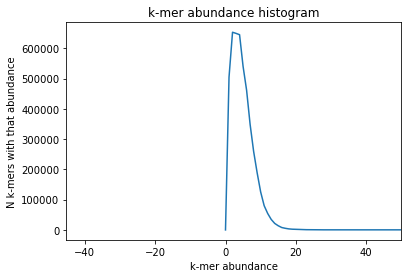

In [92]:
!abundance-dist-single.py -M 1e9 -k 21 -s ERX168346.corrected.trimmed.fq ERX168346.dist

dist1 = numpy.loadtxt('ERX168346.dist', skiprows=1, delimiter=',')
plot(dist1[:,0], dist1[:,1])
axis(xmax=50)
title('k-mer abundance histogram')
xlabel('k-mer abundance')
ylabel('N k-mers with that abundance')

So we've managed to reduce the number of low abundance k-mers in our sample using sketching.

* let's do a final round of QC now that we have fixed errors and removed k-mers:

In [98]:
!trimmomatic SE ERX168346.corrected.trimmed.fq ERX168346.clean.fq SLIDINGWINDOW:5:20 CROP:100

TrimmomaticSE: Started with arguments:
 ERX168346.corrected.trimmed.fq ERX168346.clean.fq SLIDINGWINDOW:5:20 CROP:100
Automatically using 4 threads
Quality encoding detected as phred33
Input Reads: 250557 Surviving: 250557 (100.00%) Dropped: 0 (0.00%)
TrimmomaticSE: Completed successfully


* just to finish up, let's see if our QC has improved our sketch similarity between the sample and the reference genome:

In [93]:
# recompute the sketch for our sample, this time using the QC'd reads
!sourmash compute --scaled 1000 -k 31 ERX168346.corrected.trimmed.fq --o ERX168346.sketch

# compare the sketch against the reference genomes
!sourmash gather -k 31 ERX168346.sketch genbank-k31.lca.json.gz

== This is sourmash version 2.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

setting num_hashes to 0 because --scaled is set
computing signatures for files: ERX168346.corrected.trimmed.fq
Computing signature for ksizes: [31]
Computing only nucleotide (and not protein) signatures.
Computing a total of 1 signature(s).
... reading sequences from ERX168346.corrected.trimmed.fq
calculated 1 signatures for 250557 sequences in ERX168346.corrected.trimmed.fq
saved 1 signature(s). Note: signature license is CC0.
== This is sourmash version 2.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded query: ERX168346.corrected.trimmed.fq... (k=31, DNA)
loaded 1 databases.                                                            


overlap     p_query p_match
---------   ------- -------
4.4 Mbp       97.8%   91.7%    FKBP01000001.1 Enterobacter cloacae s...
found less than 10.0 kbp in common. => exiting

found 1 matches total;
the recovered m

Great - we now have increased the amount of query matching the reference. In other words, the similarity between our sample and the reference genome has increased!

***

Let's move on to the next stage of the workflow: [resistome profiling](r4.3.Resistome-profiling.ipynb)